<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [191]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [192]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-27 07:23:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-03-27 07:23:02 (17.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [193]:
df = pd.read_csv('loan_train.csv')
df.head()
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

In [194]:
df.shape

(346, 10)

### Convert to date time object 

In [195]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [196]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [197]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: \ ^C
failed

CondaError: KeyboardInterrupt



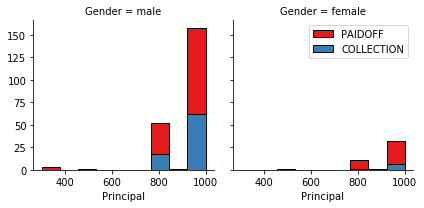

In [198]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

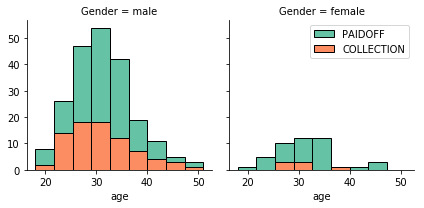

In [199]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

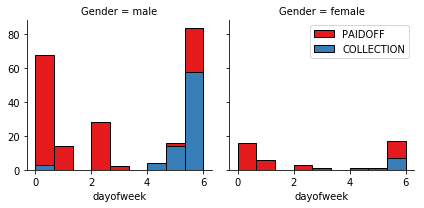

In [200]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [201]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df['Gender2']=df['Gender'].replace(to_replace=['male','female'], value=[0,1])
#df['education2']=df['education'].replace(to_replace=['High School or Below','college','Bechalor','Master or Above'], value=[0,1,2,3])
df['ResultPaid']=df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Gender2,ResultPaid
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0,0,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0,1,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1,1,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1,0,1


## Convert Categorical features to numerical values

Lets look at gender:

In [202]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [206]:
#df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['Gender2']=df['Gender'].replace(to_replace=['male','female'], value=[0,1])
df.head()
#df.education.value_counts()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Gender2,ResultPaid
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0,0,1
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0,1,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0,0,1
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1,1,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1,0,1


## One Hot Encoding  
#### How about education?

In [209]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [210]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,male,High School or Below
1,1000,30,33,female,Bechalor
2,1000,15,27,male,college
3,1000,30,28,female,college
4,1000,30,29,male,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [211]:
Feature = df[['Principal','terms','age','Gender2','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender2,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [212]:
X = Feature
X[0:5]

,Principal,terms,age,Gender2,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [213]:
y = df['ResultPaid'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [214]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [223]:

df.head()
#Getting values of loan_status
df.loan_status.value_counts()
#convert Loan Status to numerical value and add new column for model calculations
Feature['LoanStatus']=df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])

print ('Total Data Shape',Feature.shape)
#Assinging independent variable array
X=Feature[['Principal', 'terms', 'age', 'Gender2', 'weekend', 'Bechalor','High School or Below', 'college']].values

#Normalization values for model caluclations
X= preprocessing.StandardScaler().fit(X).transform(X)

#Dependent variable array
y=df['ResultPaid'].values

# spliting data between training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

#Applying KNN 
from sklearn.neighbors import KNeighborsClassifier

k = 5
#Train Model and Predict  
kneigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yknnhat = kneigh.predict(X_test)

#comparing accuracy between train and test split data set  
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, kneigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yknnhat))



Total Data Shape (346, 9)
Train set: (242, 8) (242,)
Test set: (104, 8) (104,)
Train set Accuracy:  0.8057851239669421
Test set Accuracy:  0.7307692307692307


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


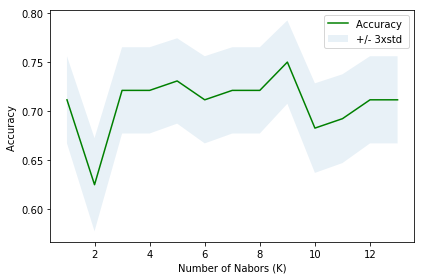

Based on itiration we find that when we use larger data to train(80/20 split) it tend to result in overfit where accuracy goes above of 80% for train data but fluctuate for test set for different values of k hence using split of 70/30 between train/test data, and find that K=5 is optimal resulting in test set accuracy of ~73 %, not choosing k=9 as there is very small incremental gain for doubling the calculation of K


In [225]:
#get to optimal value OF k
Ks = 14
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yknnhat=kneigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yknnhat)

    
    std_acc[n-1]=np.std(yknnhat==y_test)/np.sqrt(yknnhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# based on itiration we find that when we use larger data to train(80/20) we result in overfit where accuracy goes upto 77% for train data and fluctuate for test set 
#for different values of k hence using split of 70/30 between train/test data, and find that K=5 is optimal 
#for test set accuracy of .73

print('Based on itiration we find that when we use larger data to train(80/20 split) it tend to result in overfit where accuracy goes above of 80% for train data but fluctuate for test set for different values of k hence using split of 70/30 between train/test data, and find that K=5 is optimal resulting in test set accuracy of ~73 %, not choosing k=9 as there is very small incremental gain for doubling the calculation of K')

In [59]:
#Feature.head()
#yknn=df['ResultPaid'].values
#yknn[0:5]

# Decision Tree

In [245]:
#Since X and y dataset already along with train and test split we dont need to calculate them again

from sklearn.tree import DecisionTreeClassifier
LoanDTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5) # increasing depth and we have more dependent variables here

#Training model
LoanDTree.fit(X_train,y_train)
#Predicting values
ydthat = LoanDTree.predict(X_test)
#You can print out predLoanTree and ydt_testset to visually compare the prediction to the actual values.

print (ydthat [0:10])
print (y_test [0:10])

from sklearn import metrics
print("DecisionTrees's Accuracy for y_test data set is :: ", metrics.accuracy_score(y_test, ydthat))

#DecisionTree has accuracy of .74 on test set

[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1 1]
DecisionTrees's Accuracy for y_test data set is ::  0.7403846153846154


# Support Vector Machine

In [233]:
#Since X and y dataset already along with train and test split we dont need to calculate them again

#import scipy.optimize as opt


from sklearn import svm
clf = svm.SVC(kernel='poly', gamma='auto')
clf.fit(X_train, y_train) 
ysvmhat = clf.predict(X_test)
ysvmhat



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           0       0.67      0.07      0.13        27
           1       0.75      0.99      0.85        77

   micro avg       0.75      0.75      0.75       104
   macro avg       0.71      0.53      0.49       104
weighted avg       0.73      0.75      0.67       104

Confusion matrix, without normalization
[[76  1]
 [25  2]]
F1 score for y_test data set is : 0.6668539325842696
Jaccard similarity score  y_test data is : 0.75


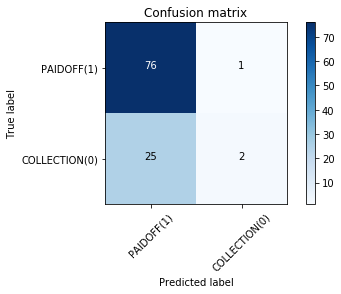

In [246]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
	# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, ysvmhat, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(y_test, ysvmhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(1)','COLLECTION(0)'],normalize= False,  title='Confusion matrix')

from sklearn.metrics import f1_score
f1_score(y_test, ysvmhat, average='weighted')

print ('F1 score for y_test data set is :',f1_score(y_test, ysvmhat, average='weighted'))

print ('Jaccard similarity score  y_test data is :',jaccard_similarity_score(y_test, ysvmhat))


# Logistic Regression

In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR2 = LogisticRegression(C=0.9, solver='saga').fit(X_train,y_train)  # choosing solver as saga as it provides best results for y_test data set
LR2

ylrhat = LR2.predict(X_test)

ylrhat_prob = LR2.predict_proba(X_test)


from sklearn.metrics import jaccard_similarity_score
print ('F1 score for y_test data set is :',f1_score(y_test, ylrhat, average='weighted'))

from sklearn.metrics import f1_score
print ('Jaccard similarity score for y_test data set is :',jaccard_similarity_score(y_test, ylrhat))

from sklearn.metrics import log_loss
print ('Log Loss for y_test data set is :',log_loss(y_test, ylrhat_prob))


F1 score for y_test data set is : 0.6709553683237893
Jaccard similarity score for y_test data set is : 0.7211538461538461
Log Loss for y_test data set is : 0.48274397735597757


[[71  6]
 [23  4]]
Confusion matrix, without normalization
[[71  6]
 [23  4]]
              precision    recall  f1-score   support

           0       0.40      0.15      0.22        27
           1       0.76      0.92      0.83        77

   micro avg       0.72      0.72      0.72       104
   macro avg       0.58      0.54      0.52       104
weighted avg       0.66      0.72      0.67       104



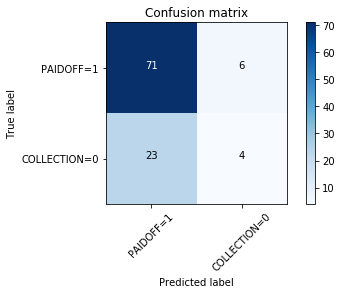

In [238]:
# confusion matrix
# Another way of looking at accuracy of classifier is to look at confusion matrix.

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, ylrhat, labels=[1,0]))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, ylrhat, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF=1','COLLECTION=0'],normalize= False,  title='Confusion matrix')

print (classification_report(y_test, ylrhat))

# Model Evaluation using Test set

In [239]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [240]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-03-27 08:01:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-03-27 08:01:42 (309 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [247]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

#df.loan_status.value_counts()
##filter
#ndf=test_df[(test_df.loan_status == 'COLLECTION')]
#ndf.head(10)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [248]:
#preparing test data and normalizing to be used to used for prediction


test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender2']=test_df['Gender'].replace(to_replace=['male','female'], value=[0,1])
#test_df['education2']=test_df['education'].replace(to_replace=['High School or Below','college','Bechalor','Master or Above'], value=[0,1,2,3])
test_df['ResultPaid']=test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0])

test_df.head(10)

#ndf=test_df[(test_df.loan_status == 'COLLECTION')]
#ndf.head(20)

#creating new  Feature for running loan_test data
FeatureTest = test_df[['Principal','terms','age','Gender2','weekend']]
FeatureTest = pd.concat([FeatureTest,pd.get_dummies(test_df['education'])], axis=1)
FeatureTest.drop(['Master or Above'], axis = 1,inplace=True)
FeatureTest.head()

print ('Total FeatureTest Shape',FeatureTest.shape)
#Assinging independent variable array
XT=FeatureTest[['Principal', 'terms', 'age', 'Gender2', 'weekend', 'Bechalor','High School or Below', 'college']].values
XT= preprocessing.StandardScaler().fit(XT).transform(XT)
XT[0:5]

#Dependent variable array
yt=test_df['ResultPaid'].values
yt[0:5]

Total FeatureTest Shape (54, 8)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([1, 1, 1, 1, 1])

In [249]:
ytknnhat = kneigh.predict(XT)
ytknnhat[0:5]

# For KNN output
print("FeatureTest set Accuracy for KNN: ", metrics.accuracy_score(yt, ytknnhat))
#70.37% accurate results on load_test.csv file
print ('Jaccard similarity score for KNN is :',jaccard_similarity_score(yt, ytknnhat))
print ('F1 score fro KNN is :',f1_score(yt, ytknnhat, average='weighted'))

# for Decision Tree 
ytdthat = LoanDTree.predict(XT)
print ('Jaccard similarity score for DecisionTree is :',jaccard_similarity_score(yt, ytdthat))
print ('F1 score fro DecisionTree is :',f1_score(yt, ytdthat, average='weighted'))

# for SVM
ytsvmhat = clf.predict(XT)
print ('Jaccard similarity score for SVM is :',jaccard_similarity_score(yt, ytsvmhat))
print ('F1 score fro SVM is :',f1_score(yt, ytsvmhat, average='weighted'))

#for Logistic Regression
ytlrhat = LR2.predict(XT)
ytlrhat_prob = LR2.predict_proba(XT)
print ('Jaccard similarity score for logistic Regression is :',jaccard_similarity_score(yt, ytlrhat))
print ('F1 score fro logistic Regression is :',f1_score(yt, ytlrhat, average='weighted'))
print ('Logistic Regression Log Loss is :',log_loss(yt, ytlrhat_prob))



FeatureTest set Accuracy for KNN:  0.7037037037037037
Jaccard similarity score for KNN is : 0.7037037037037037
F1 score fro KNN is : 0.6378600823045267
Jaccard similarity score for DecisionTree is : 0.7592592592592593
F1 score fro DecisionTree is : 0.6717642373556352
Jaccard similarity score for SVM is : 0.7592592592592593
F1 score fro SVM is : 0.6959228135698723
Jaccard similarity score for logistic Regression is : 0.7592592592592593
F1 score fro logistic Regression is : 0.6717642373556352
Logistic Regression Log Loss is : 0.47425058134904413


In [189]:
Feature.head()

,Principal,terms,age,Gender2,weekend,Bechalor,High School or Below,college,LoanStatus
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,1,0
3,1000,30,28,1,1,0,0,1,0
4,1000,30,29,0,1,0,0,1,0


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

# Prepared by 
Abhishek Joshi

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.70370 | 0.6861   | NA      |
| Decision Tree      | 0.70370 | 0.6379   | NA      |
| SVM                | 0.75926 | 0.6959   | NA      |
| LogisticRegression | 0.7593  | 0.6718   | 0.4743  |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>